In [1]:
!pip install qiskit pylatexenc qiskit-ibmq-provider


[notice] A new release of pip available: 22.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import qiskit
qiskit.__qiskit_version__
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import the IBM Q Experience
from qiskit import IBMQ

import numpy as np
import matplotlib.pyplot as plt
# Importing the Matplotlib library
%matplotlib inline


In [3]:
YOUR_IBM_Q_ACCOUNT_TOKEN = 'f7415f2b5a7f9b8231adfea68759c4f287db674fe641f9846b97d367cb6cb5b43be8f5959b7e9ee41f3173d250e77d55cbb6ea0017e9e93a49b560f401cc4ecf'

In [4]:
from qiskit import IBMQ

api_key = None
for attempt in range(3):                                                # <- (1)
    try:                                                                # <- (3)
        if api_key:
            IBMQ.save_account(api_key, overwrite=True)
        else:
            IBMQ.load_account()
        break                                                           # <- (4)
    except Exception:
        api_key = input("Enter IBMQ API Key (attempt %s): " % attempt)  # <- (2)

In [5]:
my_provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-12-24 01:28:51,136: Credentials are already in use. The existing account in the session will be replaced.


Steps to follow

1. initialise quantum circuit of sender and reciever
2. set a random key for sender
3. initialisation a polarisation table
4. send qstate to reciever
5. initialise measuring basis for reciever
6. add measurements and solve circuit on backend
7. the final result is the key which the reciever recieves
8. next we compare basis and keep only those indices which have same basis
9. next we compare the final keys corresponding to those indices if they are same then channel is secure
10. If different there is an eavesdropper and channel is not secure

In [136]:
num_qubits=15

In [7]:
def make_init(name, num):
    qregister = QuantumRegister(num, name=f'{name}-qureg')
    cregister = ClassicalRegister(num, name=f'{name}-clreg')
    circuit = QuantumCircuit(qregister, cregister)
    return qregister,cregister,circuit

In [8]:
def sender_polarisation(qcircuit, qregister, name):
    polarisation_table=[]
    for ind in range(len(qregister)):
        axis = np.random.random()

        # Randomly inialising the basis
        # vertical
        if axis>=0 and axis<0.25:
            polarisation_table.append("↕")

        # Forward diagonal
        elif axis>=0.25 and axis<0.5:
            qcircuit.h(qregister[ind])
            polarisation_table.append("⤢")

        # Horizontal
        elif axis>=0.5 and axis<0.75:
            polarisation_table.append("↔")

        # Forward diagonal
        elif axis>=0.75 and axis<1:
            qcircuit.h(qregister[ind])
            polarisation_table.append("⤡")
            
    print(f"{name}'s polarisation table:")
    print(polarisation_table)
    
    return polarisation_table

In [9]:
def send_qstate(sender_circuit, reciever_circuit, register_reciever):
    # Method to send quantum state
    print("Sending quantum state...")
    qstate = sender_circuit.qasm().split(sep=';')[4:-1]
    off = len(sender_circuit.qregs[0].name) + 3

    for ind, instruction in enumerate(qstate):
        qstate[ind] = instruction.lstrip()

    for gate in qstate:
        reg_ind = int(gate[off:-1])
        if gate[0] == 'x':
            reciever_circuit.x(register_reciever[reg_ind])
        elif gate[0] == 'h':
            reciever_circuit.h(register_reciever[reg_ind])
        elif gate[0] == 'm':
            pass
        else:
            raise Exception('Unable to parse Quantum Logic gate Instruction...')
    print('Done.')


In [10]:
def measure_table(table, circuit, register, name):
    # Method to measure and update the table
    print("Measuring quantum state...")
    for ind in range(len(register)):
        axis = np.random.random()

        if (axis >= 0 and axis < 0.25) or (axis >= 0.5 and axis < 0.75):
            table.append("✛")
        elif (axis >= 0.25 and axis < 0.5) or (axis >= 0.75 and axis <= 1):
            circuit.h(register[ind])
            table.append("✕")
    print(f"{name}'s measuring basis\n {table}")
    return table

In [55]:
def run_backend(circuit, qregister, cregister):
    # Method for running the backend
    print("Running backend...")
    for qubit_index in range(len(qregister)): 
        circuit.measure(qregister[qubit_index], cregister[qubit_index])
    backend = BasicAer.get_backend('qasm_simulator')    
    results = execute(circuit, backend=backend, shots=1024).result()
    
    plot_histogram(results.get_counts(circuit))
    results_sorted = sorted(results.get_counts().items(), key=lambda item: item[1], reverse = True)
    return results,results_sorted

In [12]:
def compare_basis(alice_table, bob_table, sender, reciever):
    # Method to compare the basis of sender and receiver
    print("Comparing basis of sender and receiver...")
    final_secret_key_qubits_to_keep = []
    final_secret_key_qubits_to_discard = []

    for ind, basis in enumerate(zip(alice_table, bob_table)):
        if (basis[0] in ["↕", "↔"]) and basis[1] == "✛":
            print(f"Same basis for qubit {ind}")
            final_secret_key_qubits_to_keep.append(ind)
        elif (basis[0] in ["⤢", "⤡"]) and basis[1] == "✕":
            print(f"Same basis for qubit {ind}")
            final_secret_key_qubits_to_keep.append(ind)
        else:
            print(f"Different basis for qubit {ind}")
            final_secret_key_qubits_to_discard.append(ind)
        print(f'- Basis for {sender} was: {basis[0]}')
        print(f'- Basis for {reciever} was: {basis[1]}')

    return final_secret_key_qubits_to_keep, final_secret_key_qubits_to_discard

In [59]:
def find_rec_key(qresults, qcircuit, name):
    secret_key_binary = list(qresults)[0][0][::-1]
    print(f"{name}'s binary key: {secret_key_binary}")
    secret_key = int(secret_key_binary,2)
    print(f"{name}'s key: {secret_key}")
    return secret_key_binary, secret_key

In [119]:
def find_final_key(sender_key, reciever_key, qubits_to_keep):
    # Method for finding the final key
    print("Finding final key...")
    sender_final_key = []
    reciever_final_key = []
    for ind in qubits_to_keep:
        sender_final_key.append(sender_key[ind])
        reciever_final_key.append(reciever_key[ind])
    sender_final_key = ''.join(sender_final_key)
    reciever_final_key = ''.join(reciever_final_key)
    return sender_final_key, reciever_final_key

In [15]:
def check_security(alice_final_key, bob_final_key):
    # Method to check if the communication is secure or tampered
    print("Checking if the communication is secure...")
    if alice_final_key == bob_final_key:
        print("The Secret Key exchange seems to have worked fine and is completely secure!!!")
    else:
        print("Warning: Possible security breach detected!")

    similarity_percentage = sum(a == b for a, b in zip(alice_final_key, bob_final_key)) / len(alice_final_key)
    print(f"Percentage of Similarity between Alice's and Bob's Final Secret Key: {similarity_percentage * 100:.2f}%")

# Alice -> Bob

In [165]:
alice_qregister, alice_cregister, alice_qcircuit = make_init('alice',num_qubits)

In [166]:
bob_qregister, bob_cregister, bob_qcircuit = make_init('bob',num_qubits)

In [167]:
eve_qregister, eve_cregister, eve_qcircuit = make_init('eve',num_qubits)

In [168]:
max_seed_sec_key = 2**num_qubits

In [169]:
print("The Maximum Random Seed of Alice's Secret Key:")
max_seed_sec_key

The Maximum Random Seed of Alice's Secret Key:


32768

In [170]:
alice_secret_key = np.random.randint(0, high = max_seed_sec_key)
alice_secret_key

2585

In [171]:
alice_secret_key_binary = np.binary_repr(alice_secret_key, num_qubits)
print("Alice's Secret Key, in binary format:")
alice_secret_key_binary

Alice's Secret Key, in binary format:


'000101000011001'

In [172]:
for ind, val in enumerate(alice_secret_key_binary):
    if val=='1':
        alice_qcircuit.x(alice_qregister[ind])

In [173]:
alice_polarisation_table=[]

In [174]:
alice_polarisation_table=sender_polarisation(alice_qcircuit,alice_qregister,"alice")

alice's polarisation table:
['↔', '⤢', '↕', '⤢', '↕', '↔', '↔', '⤡', '↔', '↕', '⤢', '↕', '↔', '⤢', '↔']


In [175]:
send_qstate(alice_qcircuit, bob_qcircuit, bob_qregister)

Sending quantum state...
Done.


In [176]:
bob_measuring_basis = measure_table([], bob_qcircuit, bob_qregister, 'bob')

Measuring quantum state...
bob's measuring basis
 ['✕', '✕', '✕', '✕', '✛', '✛', '✕', '✕', '✛', '✕', '✛', '✛', '✕', '✕', '✕']


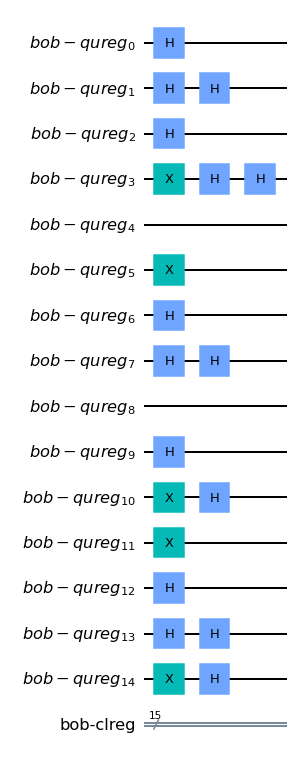

In [177]:
bob_qcircuit.draw('mpl')

In [178]:
bob_qresults, bob_qresults_sorted = run_backend(bob_qcircuit, bob_qregister, bob_cregister)

Running backend...


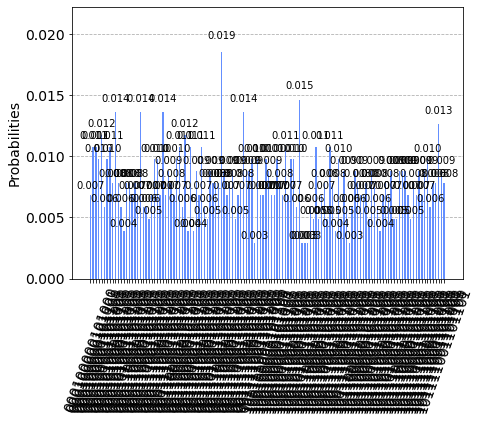

In [179]:
plot_histogram( bob_qresults.get_counts( bob_qcircuit) )

In [180]:
bob_qresults_sorted

[('001101001101101', 19),
 ('100101000101101', 15),
 ('000110000101100', 14),
 ('001110001101101', 14),
 ('000111000101100', 14),
 ('000101000101001', 14),
 ('101111001101001', 13),
 ('000100001101000', 12),
 ('001100000101100', 12),
 ('001101000101000', 11),
 ('100100001101100', 11),
 ('001100000101000', 11),
 ('100110001101100', 11),
 ('000100001101101', 11),
 ('100110000101001', 11),
 ('000100000101100', 11),
 ('001100001101000', 11),
 ('000100000101001', 11),
 ('000111000101000', 10),
 ('000100001101100', 10),
 ('100100000101101', 10),
 ('001111001101000', 10),
 ('101111000101001', 10),
 ('000100000101101', 10),
 ('000110001101101', 10),
 ('100101000101000', 10),
 ('001111000101100', 10),
 ('100111000101001', 10),
 ('100101000101001', 10),
 ('001111001101101', 10),
 ('000111001101101', 10),
 ('101110000101000', 9),
 ('001110000101101', 9),
 ('101110001101100', 9),
 ('001101000101101', 9),
 ('101101001101000', 9),
 ('100111000101101', 9),
 ('101111000101000', 9),
 ('100111001101101'

In [181]:
bob_secret_key_binary, bob_secret_key = find_rec_key(bob_qresults_sorted, bob_qcircuit, "bob")

bob's binary key: 101101100101100
bob's key: 23340


In [182]:
keep, discard = compare_basis(alice_polarisation_table, bob_measuring_basis,'alice','bob')

Comparing basis of sender and receiver...
Different basis for qubit 0
- Basis for alice was: ↔
- Basis for bob was: ✕
Same basis for qubit 1
- Basis for alice was: ⤢
- Basis for bob was: ✕
Different basis for qubit 2
- Basis for alice was: ↕
- Basis for bob was: ✕
Same basis for qubit 3
- Basis for alice was: ⤢
- Basis for bob was: ✕
Same basis for qubit 4
- Basis for alice was: ↕
- Basis for bob was: ✛
Same basis for qubit 5
- Basis for alice was: ↔
- Basis for bob was: ✛
Different basis for qubit 6
- Basis for alice was: ↔
- Basis for bob was: ✕
Same basis for qubit 7
- Basis for alice was: ⤡
- Basis for bob was: ✕
Same basis for qubit 8
- Basis for alice was: ↔
- Basis for bob was: ✛
Different basis for qubit 9
- Basis for alice was: ↕
- Basis for bob was: ✕
Different basis for qubit 10
- Basis for alice was: ⤢
- Basis for bob was: ✛
Same basis for qubit 11
- Basis for alice was: ↕
- Basis for bob was: ✛
Different basis for qubit 12
- Basis for alice was: ↔
- Basis for bob was: ✕
Sa

In [183]:
alice_final_key, bob_final_key = find_final_key(alice_secret_key_binary, bob_secret_key_binary, keep)

Finding final key...


In [184]:
print(alice_final_key, bob_final_key)

01010010 01010010


In [185]:
check_security(alice_final_key, bob_final_key)

Checking if the communication is secure...
The Secret Key exchange seems to have worked fine and is completely secure!!!
Percentage of Similarity between Alice's and Bob's Final Secret Key: 100.00%


# with Eve

alice->eve->bob

In [137]:
alice_qregister, alice_cregister, alice_qcircuit = make_init('alice',num_qubits)

In [138]:
eve_qregister, eve_cregister, eve_qcircuit = make_init('eve',num_qubits)

In [139]:
max_seed_sec_key = 2**num_qubits
print("The Maximum Random Seed of Alice's Secret Key:")
max_seed_sec_key

The Maximum Random Seed of Alice's Secret Key:


32768

In [140]:
alice_secret_key = np.random.randint(0, high = max_seed_sec_key)
alice_secret_key

26945

In [141]:
alice_secret_key_binary = np.binary_repr(alice_secret_key, num_qubits)
print("Alice's Secret Key, in binary format:")
alice_secret_key_binary

Alice's Secret Key, in binary format:


'110100101000001'

In [142]:
for ind, val in enumerate(alice_secret_key_binary):
    if val=='1':
        alice_qcircuit.x(alice_qregister[ind])

In [143]:
alice_polarisation_table=[]

In [144]:
alice_polarisation_table=sender_polarisation(alice_qcircuit,alice_qregister,"alice")

alice's polarisation table:
['↔', '↔', '↔', '↕', '↕', '⤢', '↕', '↕', '↔', '⤢', '⤡', '⤡', '↕', '↕', '↕']


In [145]:
send_qstate(alice_qcircuit, eve_qcircuit, eve_qregister)

Sending quantum state...
Done.


In [146]:
eve_measuring_basis = measure_table([], eve_qcircuit, eve_qregister, 'eve')

Measuring quantum state...
eve's measuring basis
 ['✕', '✛', '✕', '✕', '✛', '✕', '✛', '✛', '✕', '✕', '✕', '✛', '✛', '✛', '✛']


In [147]:
eve_qresults, eve_qresults_sorted = run_backend(eve_qcircuit, eve_qregister, eve_cregister)

Running backend...


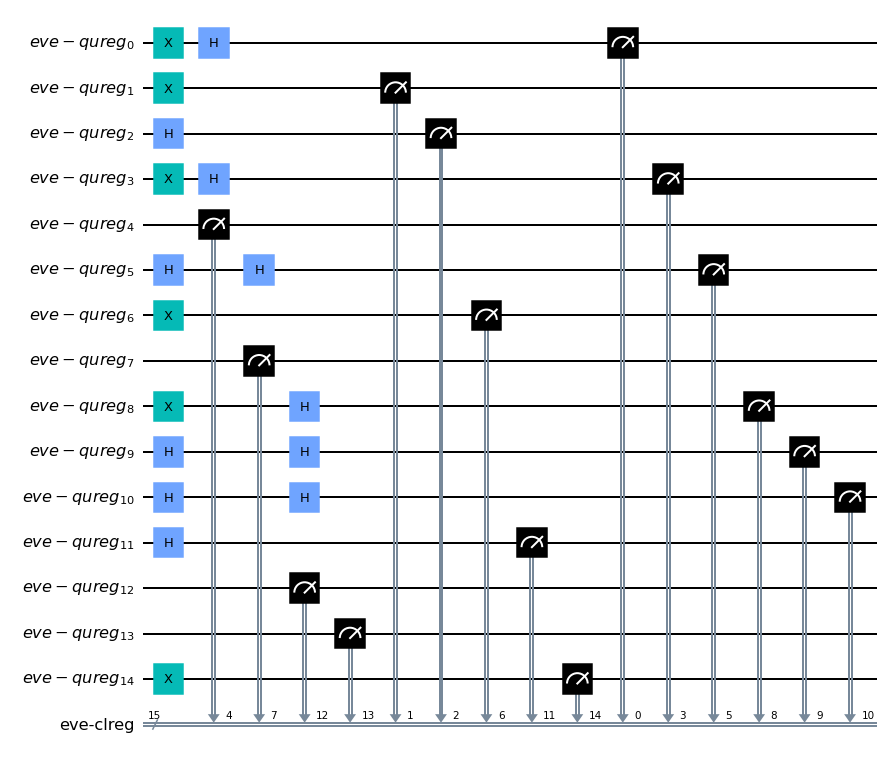

In [148]:
eve_qcircuit.draw('mpl')

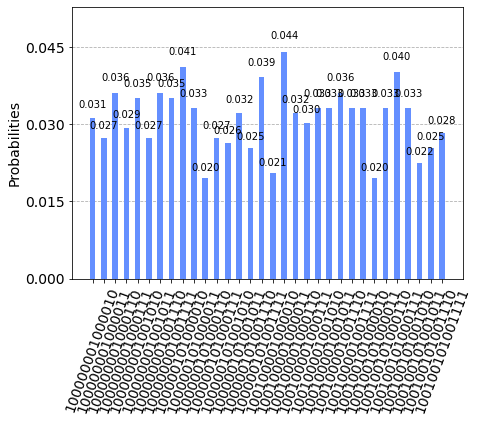

In [149]:
plot_histogram(eve_qresults.get_counts())

In [150]:
eve_secret_key_binary, eve_secret_key = find_rec_key(eve_qresults_sorted, eve_qcircuit, "eve")

eve's binary key: 110000100001001
eve's key: 24841


In [151]:
keep, discard = compare_basis(alice_polarisation_table, eve_measuring_basis,'alice','eve')

Comparing basis of sender and receiver...
Different basis for qubit 0
- Basis for alice was: ↔
- Basis for eve was: ✕
Same basis for qubit 1
- Basis for alice was: ↔
- Basis for eve was: ✛
Different basis for qubit 2
- Basis for alice was: ↔
- Basis for eve was: ✕
Different basis for qubit 3
- Basis for alice was: ↕
- Basis for eve was: ✕
Same basis for qubit 4
- Basis for alice was: ↕
- Basis for eve was: ✛
Same basis for qubit 5
- Basis for alice was: ⤢
- Basis for eve was: ✕
Same basis for qubit 6
- Basis for alice was: ↕
- Basis for eve was: ✛
Same basis for qubit 7
- Basis for alice was: ↕
- Basis for eve was: ✛
Different basis for qubit 8
- Basis for alice was: ↔
- Basis for eve was: ✕
Same basis for qubit 9
- Basis for alice was: ⤢
- Basis for eve was: ✕
Same basis for qubit 10
- Basis for alice was: ⤡
- Basis for eve was: ✕
Different basis for qubit 11
- Basis for alice was: ⤡
- Basis for eve was: ✛
Same basis for qubit 12
- Basis for alice was: ↕
- Basis for eve was: ✛
Same ba

In [152]:
bob_qregister, bob_cregister, bob_qcircuit = make_init('bob',num_qubits)

In [153]:
eve_qregister, eve_cregister, eve_qcircuit = make_init('eve',num_qubits)

In [154]:
eve_polarisation_table = sender_polarisation(eve_qcircuit, eve_qregister, "eve")

eve's polarisation table:
['⤢', '⤢', '⤡', '⤢', '⤢', '⤡', '⤢', '⤢', '↕', '↕', '↕', '⤡', '↔', '↔', '⤡']


In [155]:
send_qstate(eve_qcircuit, bob_qcircuit, bob_qregister)

Sending quantum state...
Done.


In [156]:
bob_measuring_basis = measure_table([], bob_qcircuit, bob_qregister, 'bob')

Measuring quantum state...
bob's measuring basis
 ['✛', '✕', '✛', '✕', '✛', '✛', '✕', '✕', '✛', '✛', '✛', '✕', '✛', '✛', '✕']


In [157]:
bob_qresults, bob_qresults_sorted = run_backend(bob_qcircuit, bob_qregister, bob_cregister)

Running backend...


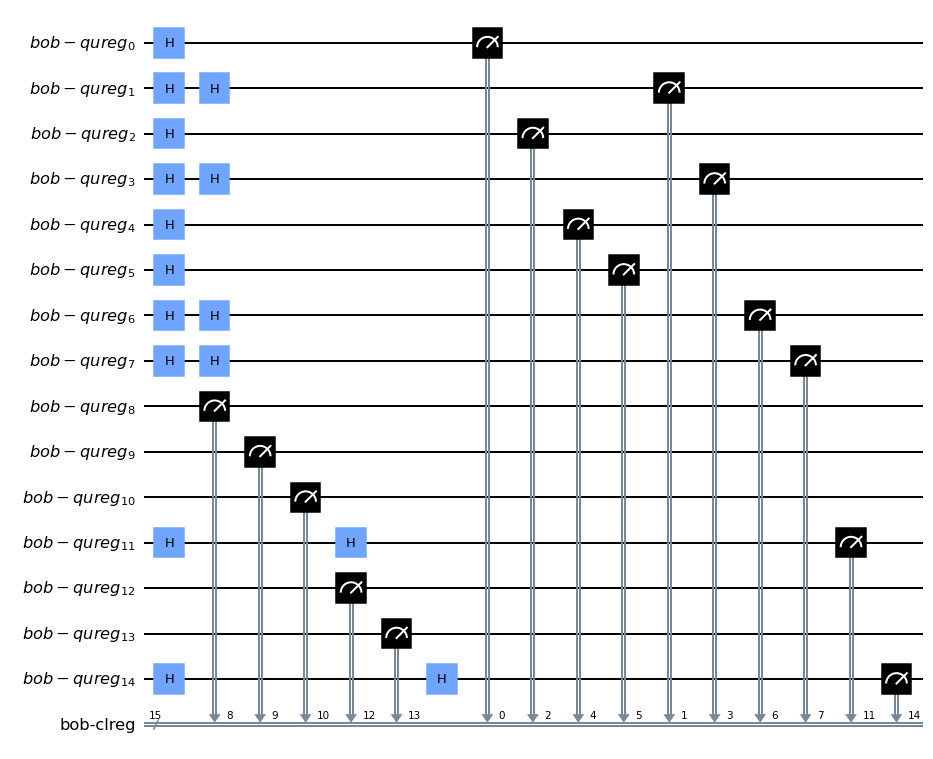

In [158]:
bob_qcircuit.draw('mpl')

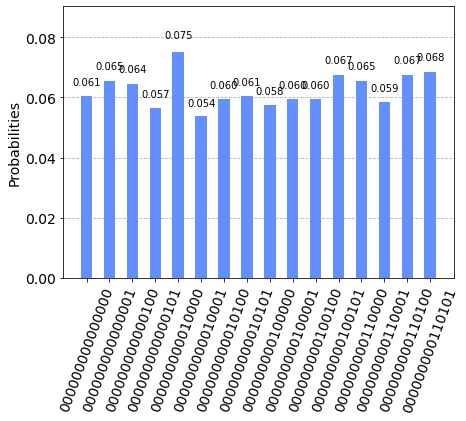

In [159]:
plot_histogram(bob_qresults.get_counts())

In [160]:
bob_secret_key_binary, bob_secret_key = find_rec_key(bob_qresults_sorted, bob_qcircuit, "bob")

bob's binary key: 000010000000000
bob's key: 1024


In [161]:
keep, discard = compare_basis(alice_polarisation_table, bob_measuring_basis,'alice','bob')

Comparing basis of sender and receiver...
Same basis for qubit 0
- Basis for alice was: ↔
- Basis for bob was: ✛
Different basis for qubit 1
- Basis for alice was: ↔
- Basis for bob was: ✕
Same basis for qubit 2
- Basis for alice was: ↔
- Basis for bob was: ✛
Different basis for qubit 3
- Basis for alice was: ↕
- Basis for bob was: ✕
Same basis for qubit 4
- Basis for alice was: ↕
- Basis for bob was: ✛
Different basis for qubit 5
- Basis for alice was: ⤢
- Basis for bob was: ✛
Different basis for qubit 6
- Basis for alice was: ↕
- Basis for bob was: ✕
Different basis for qubit 7
- Basis for alice was: ↕
- Basis for bob was: ✕
Same basis for qubit 8
- Basis for alice was: ↔
- Basis for bob was: ✛
Different basis for qubit 9
- Basis for alice was: ⤢
- Basis for bob was: ✛
Different basis for qubit 10
- Basis for alice was: ⤡
- Basis for bob was: ✛
Same basis for qubit 11
- Basis for alice was: ⤡
- Basis for bob was: ✕
Same basis for qubit 12
- Basis for alice was: ↕
- Basis for bob was:

In [162]:
alice_final_key, bob_final_key = find_final_key(alice_secret_key_binary, bob_secret_key_binary, keep)

Finding final key...


In [163]:
print(alice_final_key, bob_final_key)

1001000 0010000


In [164]:
check_security(alice_final_key, bob_final_key)

Checking if the communication is secure...
Percentage of Similarity between Alice's and Bob's Final Secret Key: 57.14%
